In [13]:

%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.kernel_approximation import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.neural_network import *
from sklearn.linear_model import *
import xgboost as xgb
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, MissingIndicator
from statsmodels.tsa.statespace.sarimax import SARIMAX
from imblearn.over_sampling import SMOTE
from imblearn.combine import *
from imblearn.ensemble import *

from numba import jit

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'


df = load_df()


def to_category(df: pd.DataFrame, feature: str):
    df[feature] = df[feature].astype("category")
    return df


def to_bool(df: pd.DataFrame, feature: str):
    df[feature] = df[feature].astype(bool)
    return df


def recast_categorical(df: pd.DataFrame, to_cat=True):
    features = [
        "naive_strategy_action",
        "workday",
        "is_balanced"
    ]
    
    func = to_category if to_cat else to_bool
    for feature in features:
        df = func(df, feature)
    return df


def lag_df(df: pd.DataFrame):
    features = {
        "min_price_published": [1],
        "max_price_published": [1],
        "fix_two_sided_ptu": [17],
        "settlement_price_realized": [17],
        "minute_in_ptu": [2]
        
    }
    lagged_features = []
    for feature, amounts in features.items():
        for amount in amounts:
            df = lag(df, feature, amount)
            lagged_features.append(df.columns[-1])
    return df, lagged_features


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

# TODO NOT WORKING
def add_daily_count(df: pd.DataFrame, base="target", output=""):
    out = df[f"{base}_two_sided_ptu_alt"].cumsum() // 15 % 96
    print((df[f"{output}two_sided_daily_count"] - out).mean())
    # df[f"{output}two_sided_daily_count"] = out
    return df


def add_time_since(df: pd.DataFrame, base="target", output=""):
    @jit
    def count_after(realtime: np.ndarray):
        out = np.empty_like(realtime, dtype=np.float_)
        count = 0
        add = 1 / 15  # time_since_last_two_sided counts not in minutes but in PTUs
        for i in range(len(realtime)):
            if realtime[i]:
                count = 0
            else:
                count += add
            out[i] = count
        return out
    
    out = count_after(df[f"{base}_two_sided_ptu_realtime"].to_numpy())
    # NOTE Code for comparisons, computed is different to given
    # df["settlement_price_bestguess"] = out
    # print((np.isclose(df[f"{version}time_since_last_two_sided"], out, atol=0.001)).mean())
    
    df[f"{output}time_since_last_two_sided_alt"] = out
    return df


def add_bestguess_alt(df: pd.DataFrame, version=""):
    mask = df[f"{version}settlement_price_bestguess"].isna()
    df[f"{version}settlement_price_bestguess_alt"] = df[f"{version}settlement_price_bestguess"]
    df.loc[mask, f"{version}settlement_price_bestguess_alt"] = df.loc[mask, "mid_price_published"]
    return df


def add_fix_features(df: pd.DataFrame):
    def set_first_two_false(group):
        group.iloc[:2] = False
        return group

    transform_dict = {
        "fix_min_ptu_price_known": ["min_price_published", "cummin"],
        "fix_max_ptu_price_known": ["max_price_published", "cummax"],
    }
    for fixed, [feature, operation] in transform_dict.items():
        df[fixed] = df.groupby("fix_ptu_id")[feature].transform(operation)
        df[fixed] = df.groupby("fix_ptu_id")[fixed].ffill()

    df["fix_settlement_price_bestguess"] = df["fix_min_ptu_price_known"]
    mask = df["fix_max_ptu_price_known"].notna()
    df.loc[mask, "fix_settlement_price_bestguess"] = df.loc[mask, "fix_max_ptu_price_known"]
    
    df = add_bestguess_alt(df, "fix_")
    
    df["fix_settlement_price_realized"] = df.groupby("fix_ptu_id")["fix_settlement_price_bestguess_alt"].transform("last")
    
    df["fix2_two_sided_ptu_realtime"] = mask & df["fix_min_ptu_price_known"].notna()
    df["fix2_two_sided_ptu_alt"] = df.groupby("fix_ptu_id")["fix_two_sided_ptu_realtime"].transform("any")
    df["fix2_two_sided_ptu"] = df.groupby("fix_ptu_id")["fix_two_sided_ptu_alt"].transform(set_first_two_false)
    
    return df

df["income"] = 0.0
df.loc[df["naive_strategy_action"], "income"] = -(100 / 60) * df.loc[df["naive_strategy_action"], "settlement_price_realized"]

df["started_down"] = df["min_price_published"].notna()
df["started_down"] = df.groupby("fix_ptu_id")["started_down"].transform("first")

df = add_bestguess_alt(df)
df = add_fix_features(df)
# df = add_time_since(df)
df = add_time_since(df, "fix2")
# df = add_daily_count(df, "fix2")

df, lagged_features = lag_df(df)
# df = recast_categorical(df)

df["max_price_filled_known"] = df["max_ptu_price_known"]
mask = df["max_ptu_price_known"].isna()
df.loc[mask, "max_price_filled_known"] = df.loc[mask, "mid_price_published"]
df["last_15min_up_volume"] = df["upward_dispatch_published"].rolling(15, 1).sum()
df["last_15min_down_volume"] = df["downward_dispatch_published"].rolling(15, 1).sum()

# from tweedejaars_project import config
# df["reconstruction"] = np.log1p(load_df(config.PROCESSED_DATA_DIR / "reconstruction_error.pkl"))
# df["last_15min_recon"] = df["reconstruction"].rolling(15, 1).mean()
# df["recon_diff"] = df["last_15min_recon"].diff()

# mask = df["fix_two_sided_ptu_17"].fillna(False)
# df["last_15min_recon_true"] = np.nan
# df.loc[mask, "last_15min_recon_true"] = df.loc[mask, "reconstruction"].rolling(15, 1).mean()
# df["last_15min_recon_true"] = df["last_15min_recon_true"].ffill()
# df["recon_diff_true"] = df["last_15min_recon_true"].diff()

# mask = ~df["fix_two_sided_ptu_17"].fillna(False)
# df["last_15min_recon_false"] = np.nan
# df.loc[mask, "last_15min_recon_false"] = df.loc[mask, "reconstruction"].rolling(15, 1).mean()
# df["last_15min_recon_false"] = df["last_15min_recon_false"].ffill()
# df["recon_diff_false"] = df["last_15min_recon_false"].diff()

# df["recon_diff_total"] = (df["recon_diff_true"] - df["recon_diff_false"]) - (df["recon_diff"] - df["recon_diff_false"])

# encoded = load_df(config.PROCESSED_DATA_DIR / "encoded.pkl")
# encoded.columns = [str(i) for i in range(32)]

# df = pd.concat([df, encoded], axis=1)

# price_pred = load_df(config.PROCESSED_DATA_DIR / "price_pred.pkl")
# df["price_pred"] = price_pred

# df.fillna(0, inplace=True)

version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Number of used features: 44
count    128.000000
mean       0.152484
std        0.004361
min        0.142337
25%        0.150268
50%        0.152724
75%        0.155086
max        0.163536
Name: 0, dtype: float64


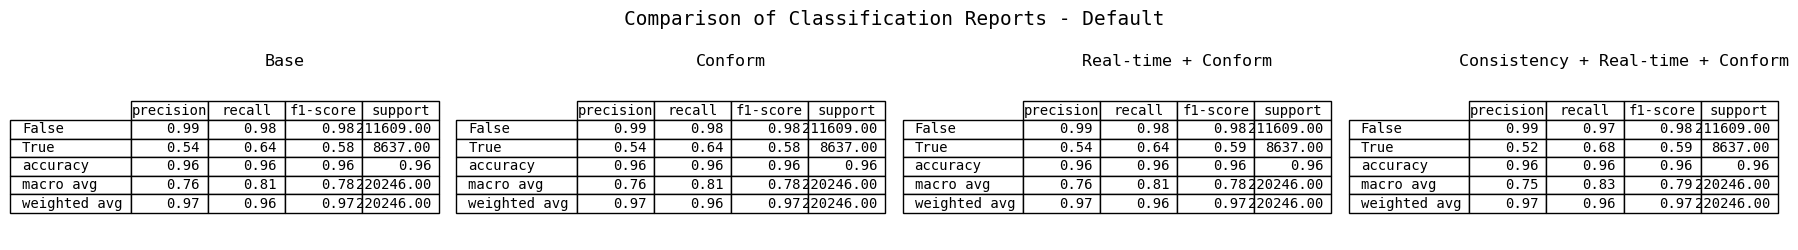

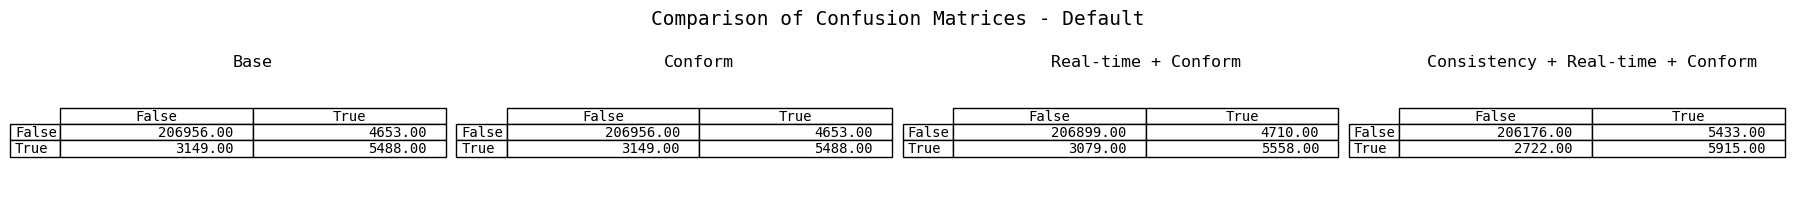

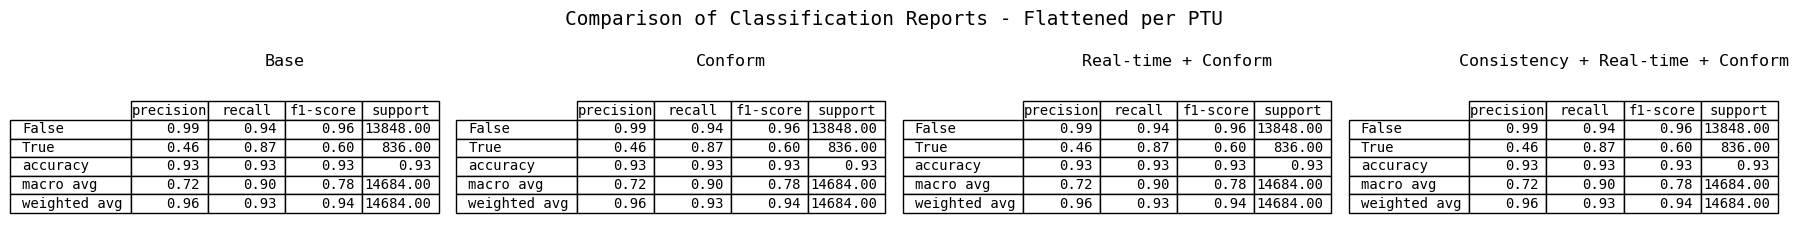

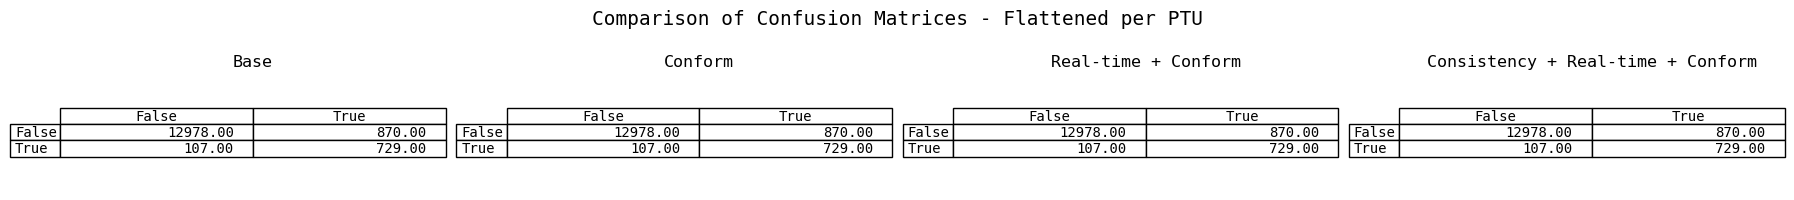

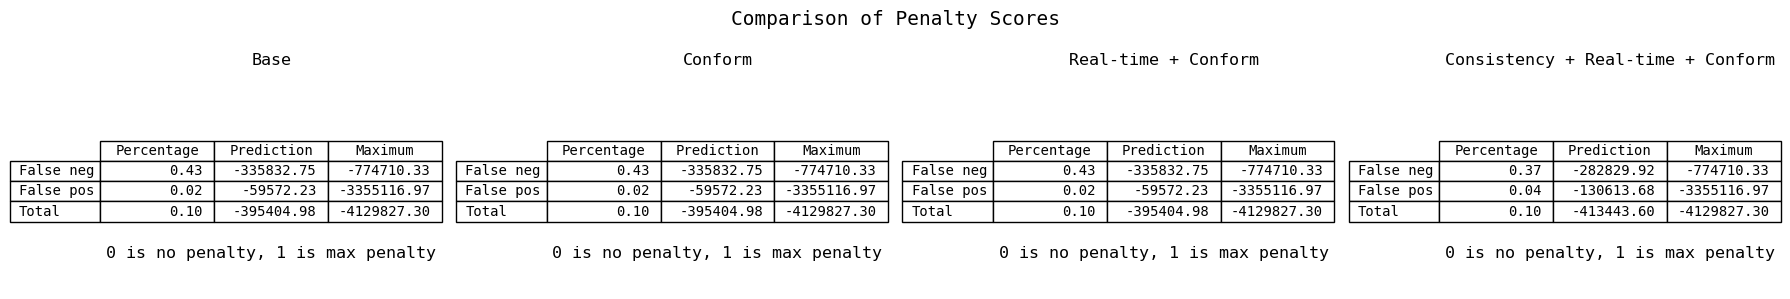

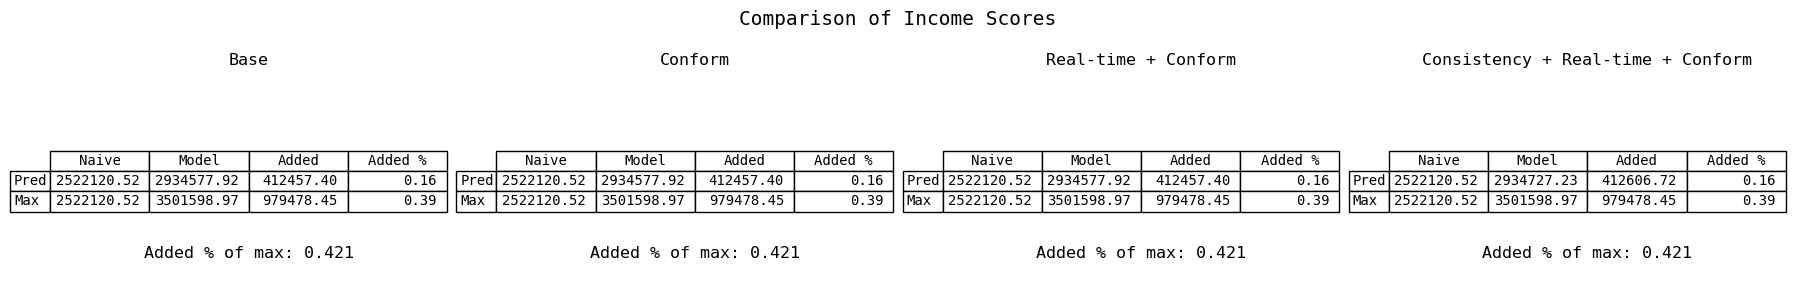

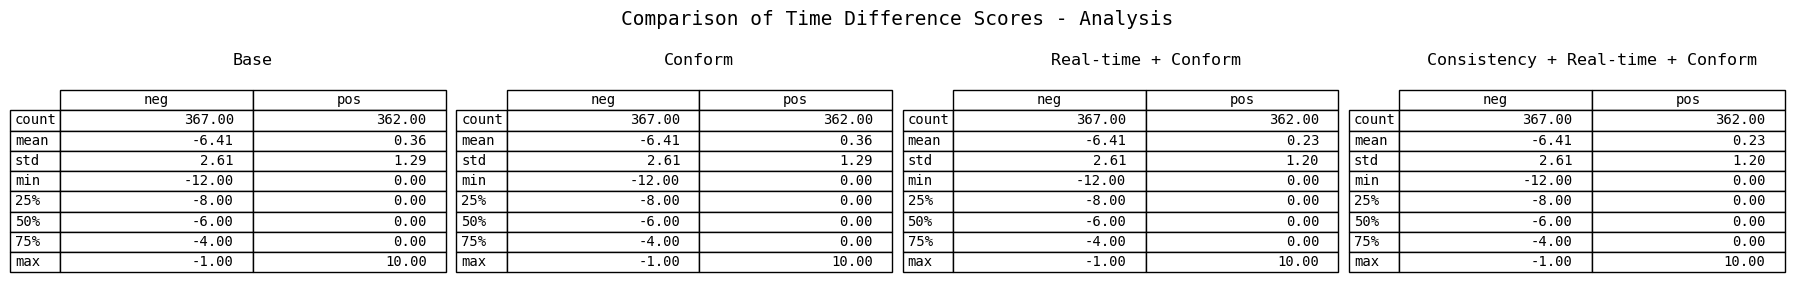

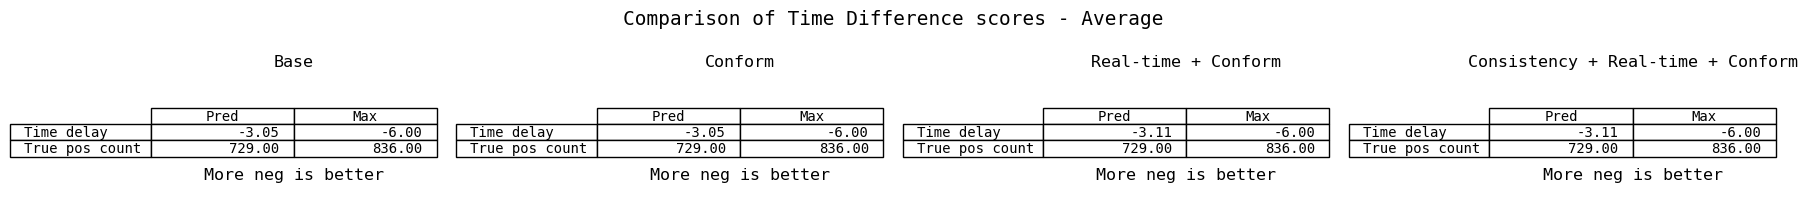

In [14]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "fix_min_ptu_price_known",  # combine all
    "fix_max_ptu_price_known",  # combine all
    "fix_settlement_price_bestguess_alt",  # combine all
    "settlement_price_bestguess_alt",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    # "igcc_contribution_up_published",
    # "igcc_contribution_down_published",
    "time_since_last_two_sided",
    "time_since_last_two_sided_alt",  # combine all
    "two_sided_daily_count",
    "PTU",
    "minute_in_ptu",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    # "forecast_wind",
    # "forecast_solar",
    # "forecast_demand",
    # "forecast_wind_delta",
    # "forecast_solar_delta",
    # "forecast_demand_delta",
    "fix_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    # "hour",
    "month",
    # "day",
    # "minute",
    # "down_negative",
    "down_price_volume",
    "up_price_volume",
    # "diff_price_volume",
    # "started_down",
    # "max_price_filled_known",
    "last_15min_up_volume",
    "last_15min_down_volume",
    "downward_dispatch_published_peak",
    "downward_dispatch_published_peak_time",
    "downward_dispatch_published_peak_diff",
    # "upward_dispatch_published_peak",
    # "upward_dispatch_published_peak_time",
    # "upward_dispatch_published_peak_diff",
    "igcc_contribution_down_published_peak",
    "igcc_contribution_down_published_peak_time",
    "igcc_contribution_down_published_peak_diff",
    # "igcc_contribution_up_published_peak",
    # "igcc_contribution_up_published_peak_time",
    # "igcc_contribution_up_published_peak_diff",
    # "reconstruction",
    # "last_15min_recon",
    # "recon_diff",
    # "last_15min_recon_true",
    # "recon_diff_true",
    # "last_15min_recon_false",
    # "recon_diff_false",
    # "recon_diff_total",
    # "price_pred"
] + lagged_features

print("Number of used features:", len(features))
splits = get_splits(df, features, target, return_dict_pair=False)



def train(train_in, train_out):
    # categorical_columns = train_in.columns[train_in.dtypes == "category"]
    # one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    # cyclic_spline_transformer = ColumnTransformer(
    #     transformers=[
    #         ("categorical", one_hot_encoder, categorical_columns),
    #         ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
    #         # ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    #         ("cyclic_PTU", periodic_spline_transformer(96, n_splines=48), ["PTU"]),
    #         ("cyclic_minute_in_ptu", periodic_spline_transformer(15, n_splines=7), ["minute_in_ptu"]),
    #     ],
    #     remainder=MinMaxScaler(),
    #     n_jobs=-1
    # )
    # model = make_pipeline(
    #     cyclic_spline_transformer,
    #     # SimpleImputer(),
    #     # Nystroem(kernel="poly", degree=2, n_components=300, random_state=0, n_jobs=-1),
    #     # RidgeClassifierCV(),
    #     # HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype"),
    #     memory="cache/test3"
    # )
    # model = make_pipeline(
    #     # transformer,
    #     # IterativeImputer(sample_posterior=True, initial_strategy="mean", max_iter=100, skip_complete=True, add_indicator=True),
    #     MinMaxScaler(),
    #     SimpleImputer(),
    #     RidgeCV()
    #     # HistGradientBoostingRegressor(loss="poisson", l2_regularization=4, learning_rate=0.3, validation_fraction=0.2)
    #     # ExtraTreesRegressor(n_jobs=-1)
    # )
    model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")
    # model = xgb.XGBClassifier(objective="binary:hinge", subsample=0.9, tree_method="hist", grow_policy="lossguide", max_depth=8)
    # h = HistGradientBoostingClassifier(scoring="average_precision", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")
    # model = SARIMAX(train_out, exog=train_in, order=(5, 1, 0))
    # model = RandomForestRegressor(n_estimators=200, criterion="poisson", max_features="log2", n_jobs=-1)
    # f = RandomForestClassifier(n_estimators=50, criterion="log_loss", max_features="log2", class_weight="balanced", n_jobs=-1)
    # r = RUSBoostClassifier()
    # b = BalancedBaggingClassifier(n_jobs=-1)
    # model = VotingClassifier(
    #     [
    #         ("hist", h),
    #         ("rus", r),
    #         ("bal", b),
    #         ("rf", f)
    #     ],
    #     voting="soft",
    #     n_jobs=-1
    # )
    # model = IsolationForest()

    model = model.fit(train_in, train_out)
    
    return model


def test(model, test_in):
    # pred = model.forecast(steps=len(test_in), exog=test_in)
    pred = model.predict(test_in)
    return recast_pred(pred > 0.5), pred


# splits[train_set][3]["neg"] = splits[train_set][3]["min_price_published"] < 0
# mask = splits[train_set][3].groupby("ptu_id")["neg"].transform("any")
# mask = splits[train_set][3].groupby("ptu_id")["naive_strategy_action"].transform("any")
# mask = mask | splits[train_set][3]["fix_two_sided_ptu"]
# mask = splits[train_set][3]["naive_strategy_action"] | splits[train_set][3]["fix_two_sided_ptu"]

# mask = ~splits[train_set][3]["minute_in_ptu"].isin([0, 1])  # Maybe prob no
mask = splits[train_set][3]["started_down"]

t = np.ones(len(mask), dtype=bool)
t[:15 * 2] = False
mask = mask & t

# mask = splits[train_set][3]["min_ptu_price_known"] < 0


# def upsample(train_in, train_out, factor=1):
#     sample_in = train_in[train_out]
#     sample_out = train_out[train_out]
#     for _ in range(factor):
#         train_in = pd.concat([train_in, sample_in])
#         train_out = pd.concat([train_out, sample_out])
#     return train_in, train_out

# splits[train_set][0], splits[train_set][1] = upsample(splits[train_set][0], splits[train_set][1])

# splits[test_set][3] = recast_categorical(splits[test_set][3], False)

X_train = splits[train_set][0][mask]
y_train = splits[train_set][1][mask]

# smote = SMOTETomek()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train.fillna(0), y_train.fillna(0))
# print("start")
# best1, _ = evaluate_income(train, test, X_train_resampled, y_train_resampled, splits[test_set][0], splits[test_set][3], repeat=128)
best2, _ = evaluate_income(train, test, X_train, y_train, splits[test_set][0], splits[test_set][3], repeat=128)

# p1, p1p = test(best1[0], splits[test_set][0])
p2, p2p = test(best2[0], splits[test_set][0])
# p = p1 & p2
p = p2
show_metrics_adjusted(splits[test_set][3], p, version=version)

# TODO
# Make target the penalty
# Use the 2 min delay (done ish)
# price realized use
# Use ransac or something to better fit the minute in ptu
# Drop cutoff ptus
# Cache penalties
# Fix naive strategy action
# Fix pred fix max
# Skip train first 2 in ptu since it doesnt matter
# ...

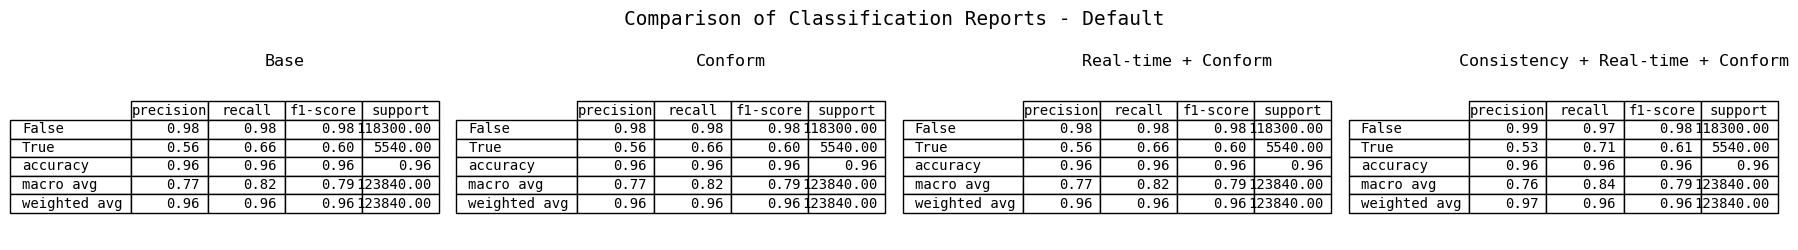

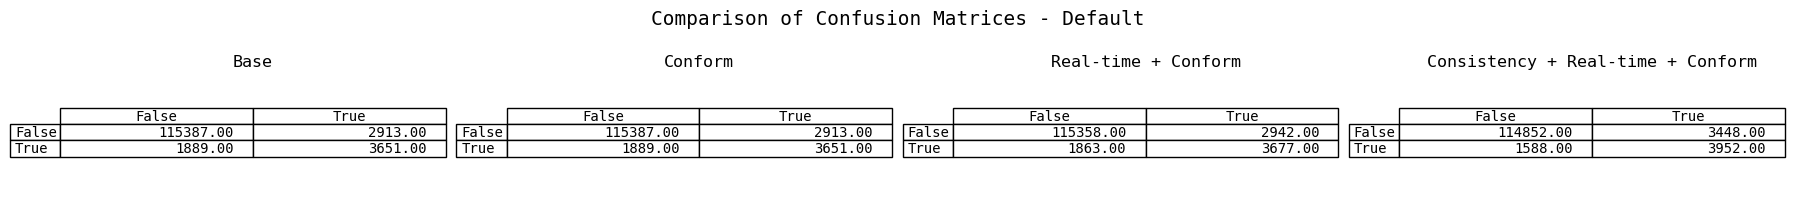

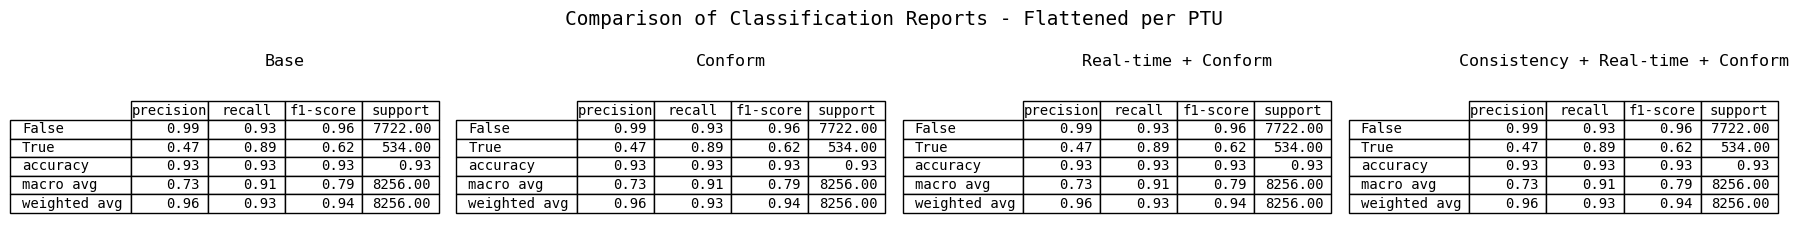

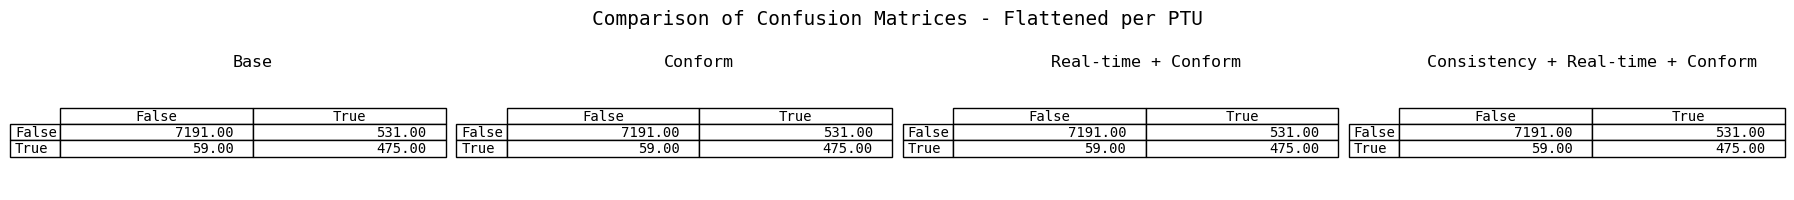

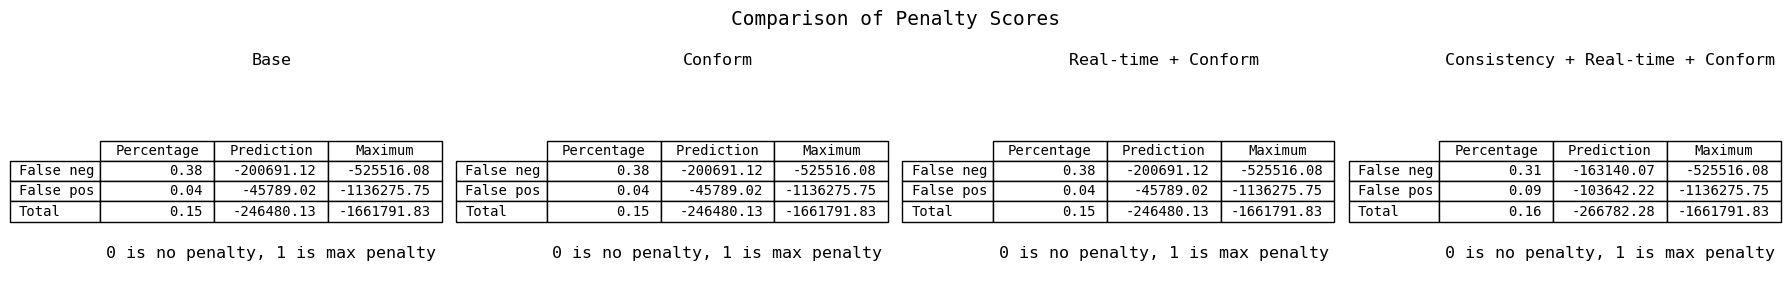

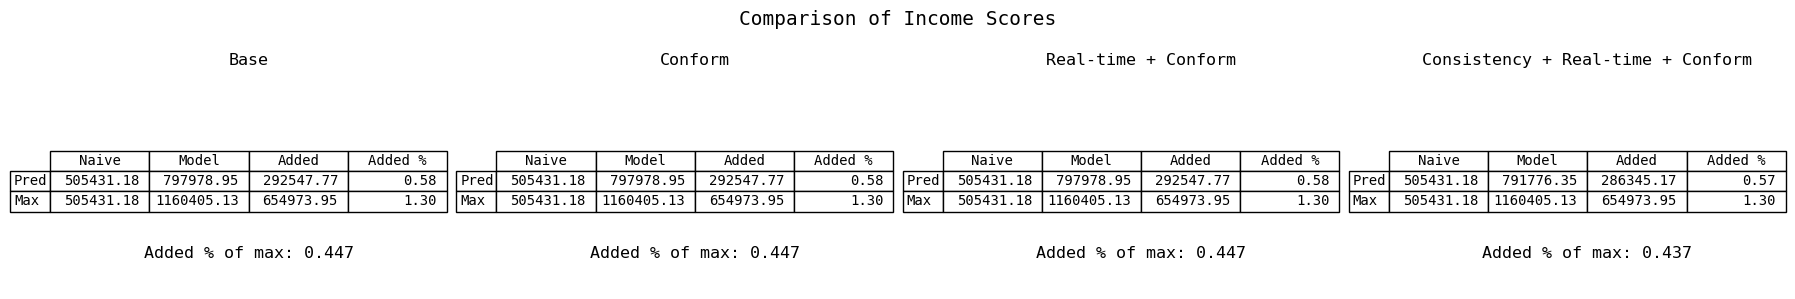

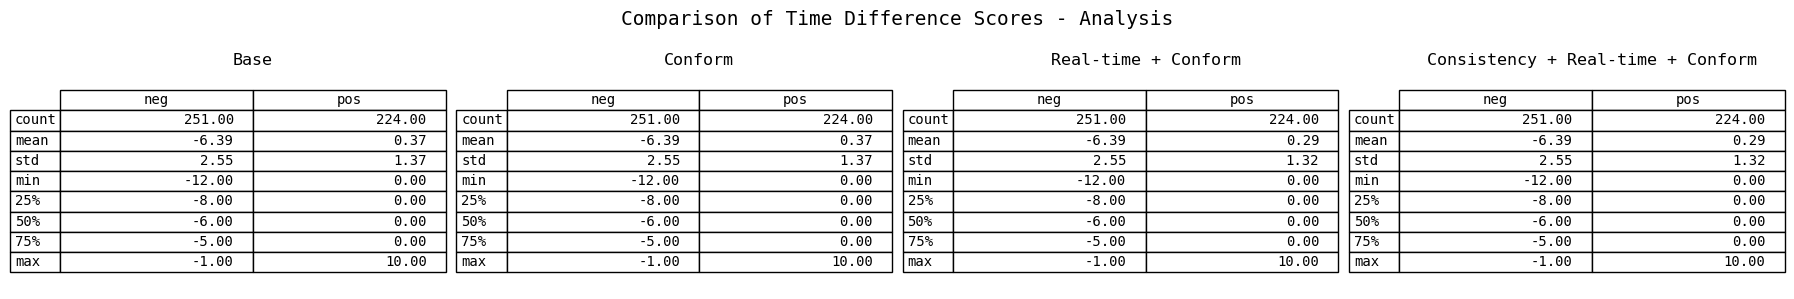

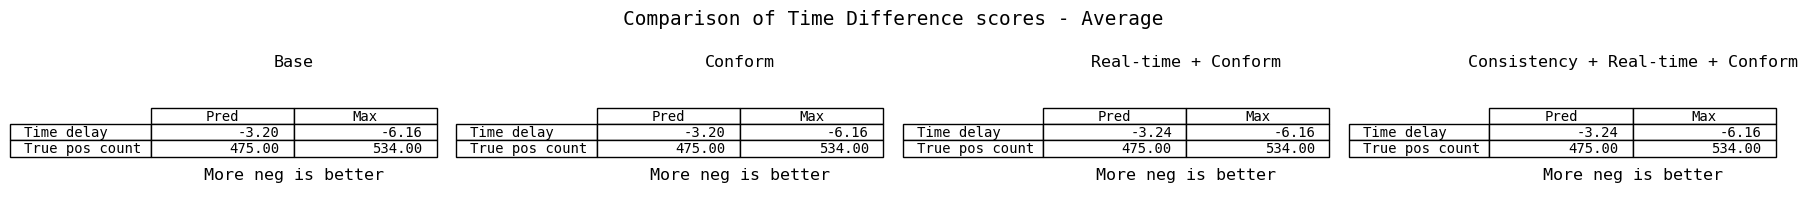

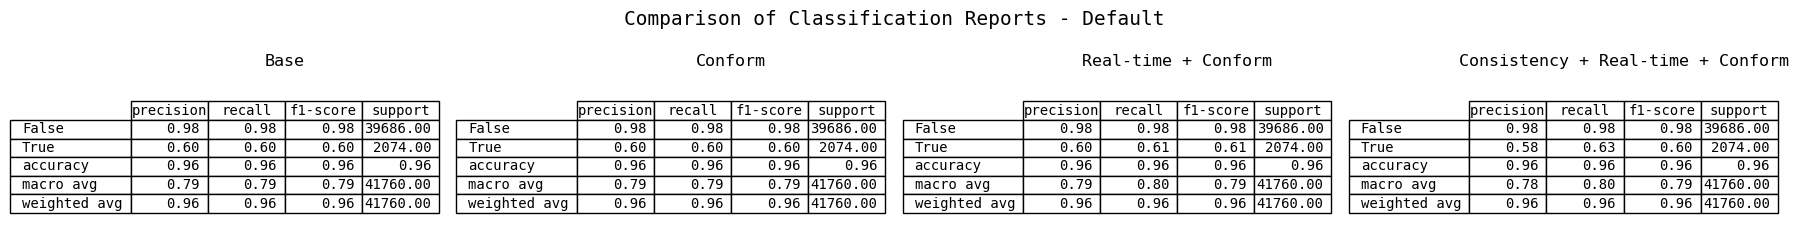

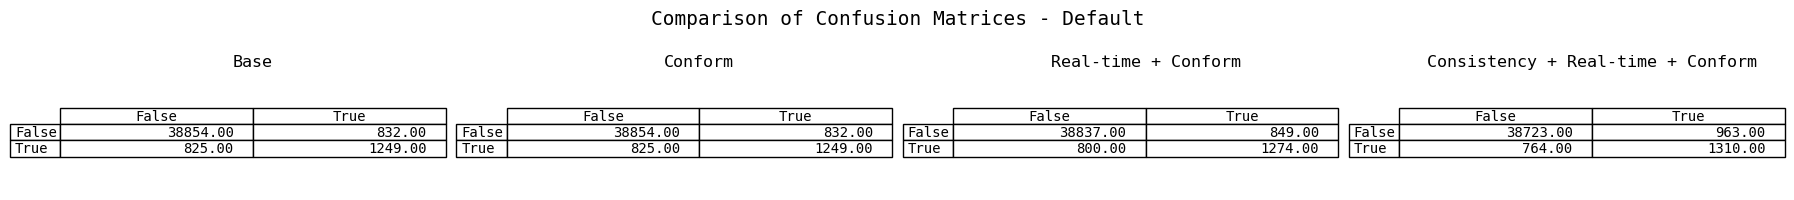

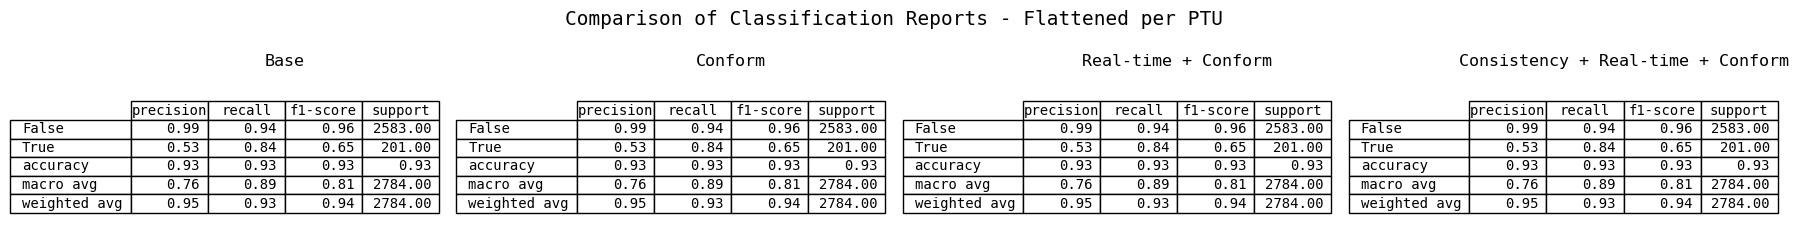

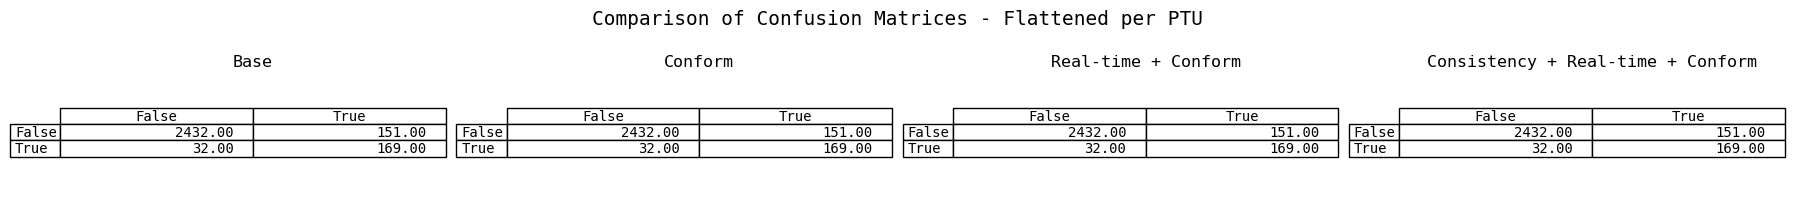

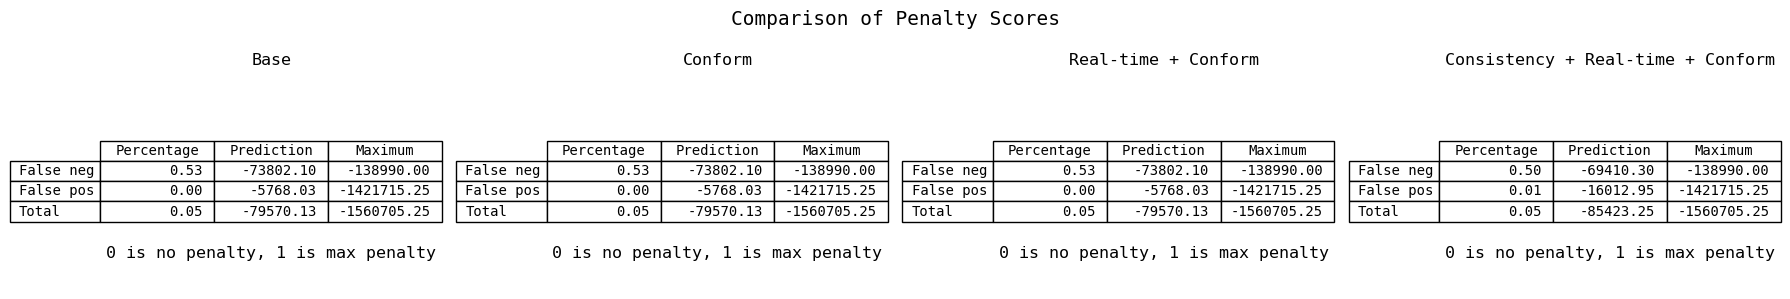

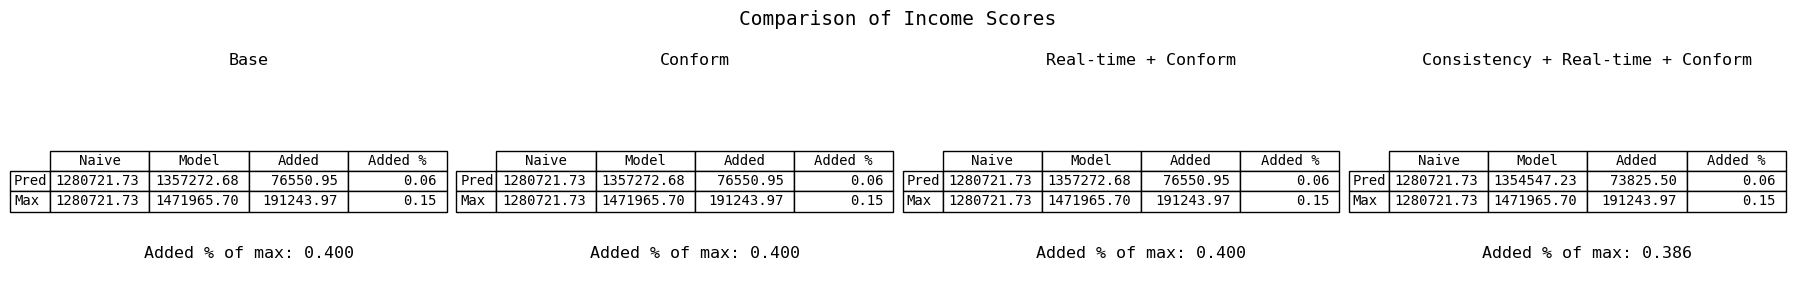

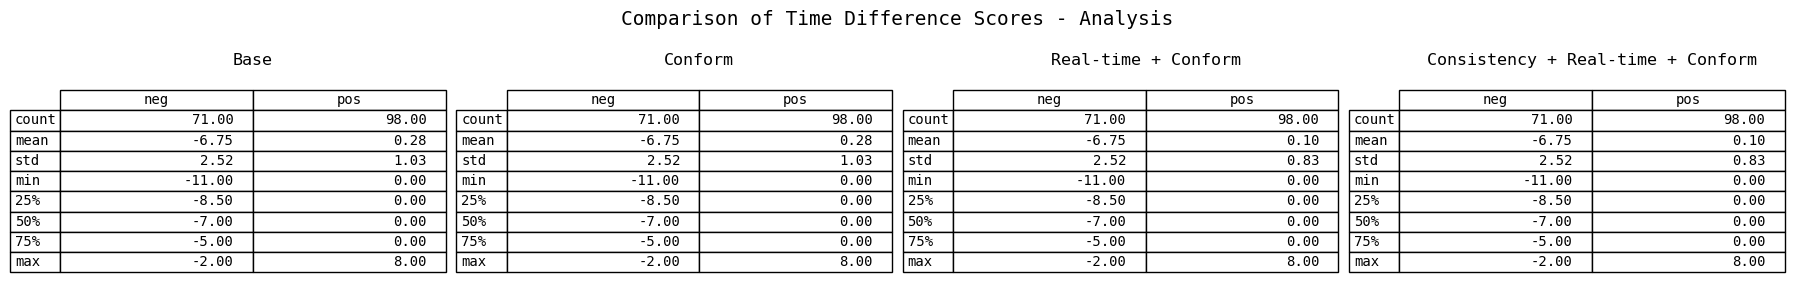

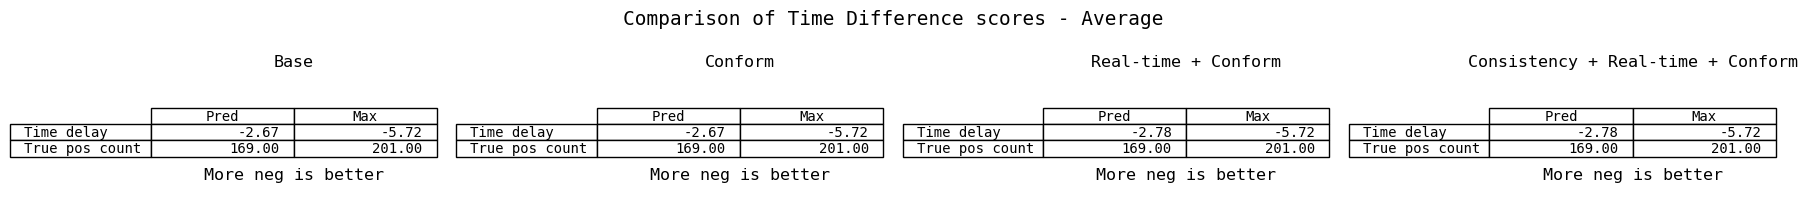

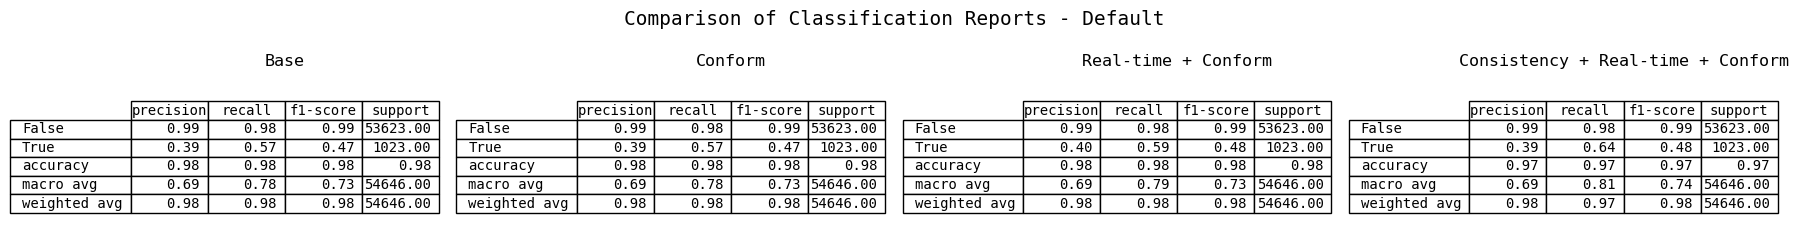

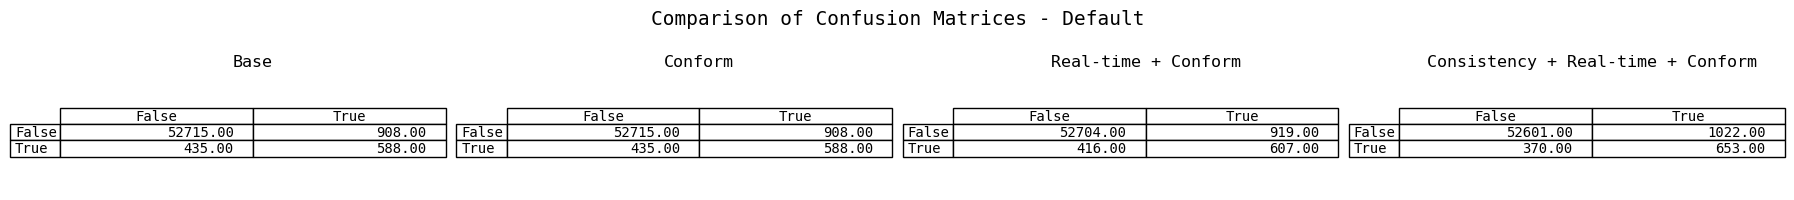

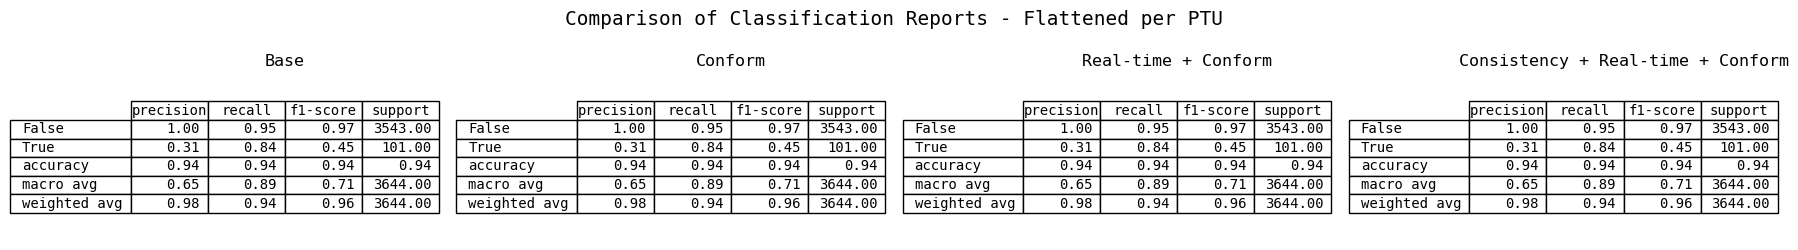

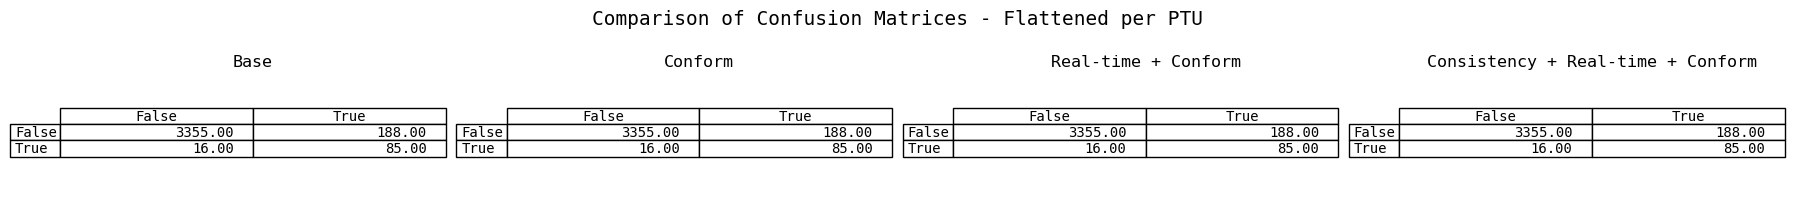

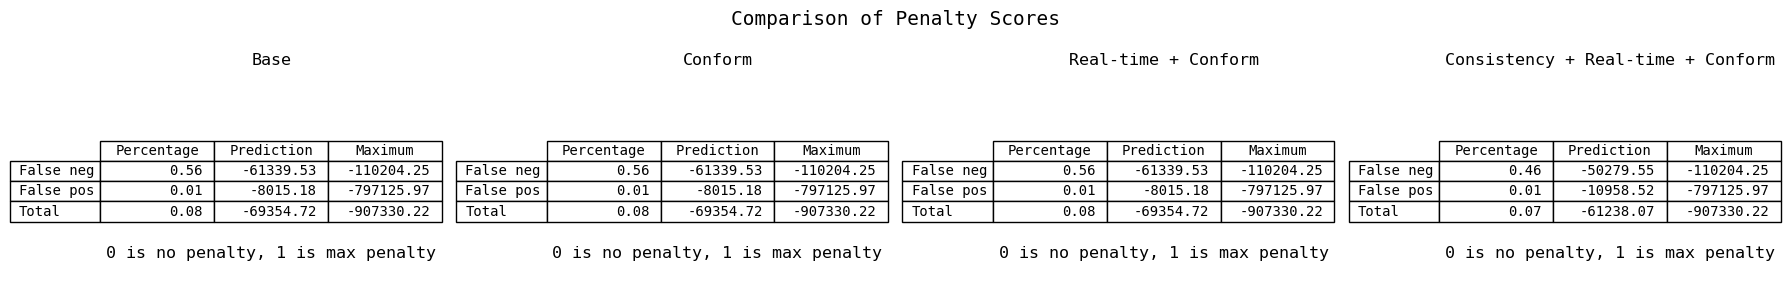

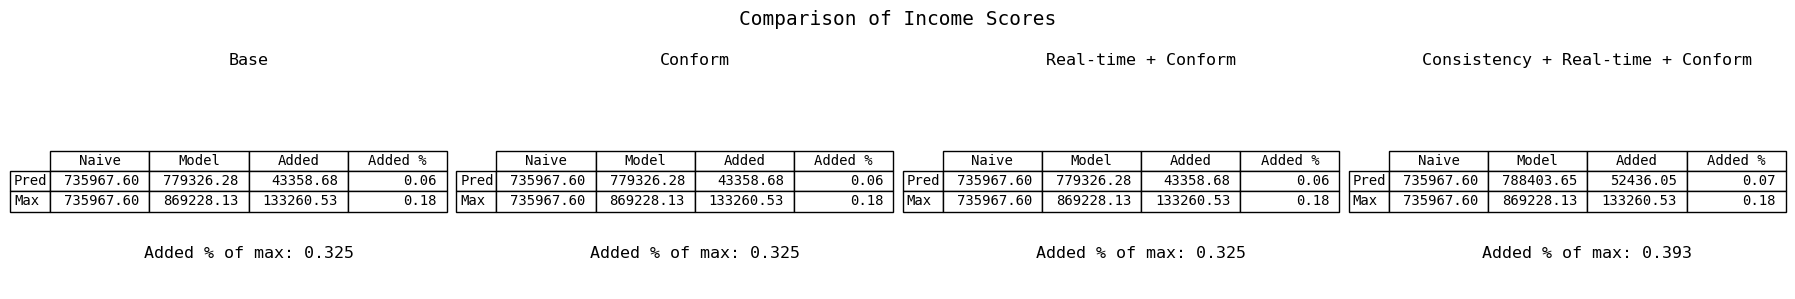

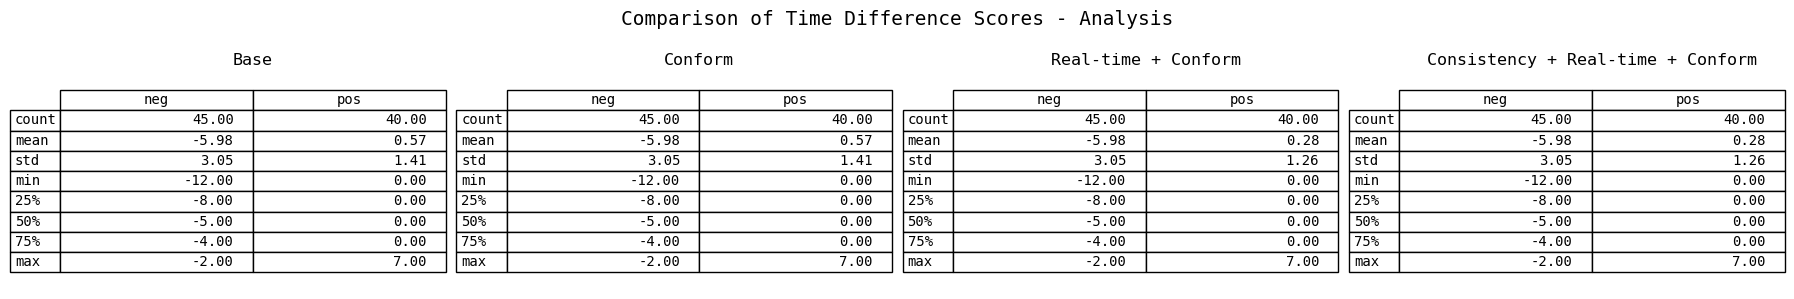

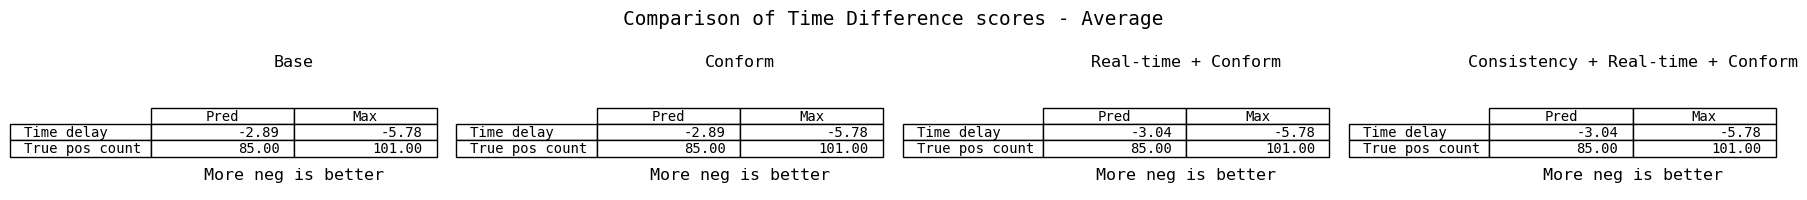

In [15]:
p_tr, _ = test(best2[0], splits["train"][0])
show_metrics_adjusted(splits["train"][3], p_tr, version=version)

p_va, _ = test(best2[0], splits["valid"][0])
show_metrics_adjusted(splits["valid"][3], p_va, version=version)

p_te, _ = test(best2[0], splits["test"][0])
show_metrics_adjusted(splits["test"][3], p_te, version=version)

In [16]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    # "target_two_sided_ptu_realtime",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    # "fix_two_sided_ptu_realtime",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = p1
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()

NameError: name 'p1' is not defined